In [37]:
import math
import os
import time 
import torch

# Train, validation, and test set
1. Train set: Used in the training pass to update the model.
2. Validation set: Used to evaluate how the model is generalizing to the problem domain, rather than fitting to the training data; not used to update the model directly.
3. Test set: A final dataset that provides a finial evaluation of the model's performance after training is complete.

In [38]:
# global params
batch_size_train = 32
batch_size_val = 32
batch_size_test = 32

num_worker = 0

In [39]:
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
# define a transform function
# for the transform function of train dataset, we try some data augmentation tricks.
train_transforms = transforms.Compose([
    transforms.Resize(28), # lower the resolution
    transforms.ToTensor(), # convert image data into tensor
    transforms.RandomAffine(degrees=20, translate=None, scale=None, shear=None, resample=None),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.Resize(28), # lower the resolution
    transforms.ToTensor(), # convert image data into tensor
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

# get training dataset
path = os.path.join(os.getcwd(), 'datasets')
train_data_path = os.path.join(path, "train")
test_data_path = os.path.join(path, "test")

if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(train_data_path)
    os.mkdir(test_data_path)
else:
    pass

# Once the dowload is finished, it won't be excuted agiain. 
train_data = torchvision.datasets.MNIST(root=train_data_path, train=True, transform=train_transforms, download=True)
test_data = torchvision.datasets.MNIST(root=test_data_path, train=False, transform=test_transforms, download=True)

# Get the validation dataset
train_data, val_data = random_split(train_data, lengths=[int(0.8 * len(train_data)), int(0.2 * len(train_data))], 
                                    generator=torch.Generator().manual_seed(42))

# To construct dataloader
train_data_loader = DataLoader(dataset=train_data, 
                                batch_size=batch_size_train, 
                                shuffle=True,
                                num_workers=num_worker)

val_data_loader = DataLoader(dataset=val_data, 
                                batch_size=batch_size_val, 
                                shuffle=True,
                                num_workers=num_worker)

test_data_loader = DataLoader(dataset=test_data, 
                                batch_size=batch_size_test, 
                                shuffle=True,
                                num_workers=num_worker)

In the 0-th batch, the shape of loaded data: torch.Size([32, 1, 28, 28]) in format [batch_size, channels, width, height], 
 and the targets are in shape torch.Size([32])


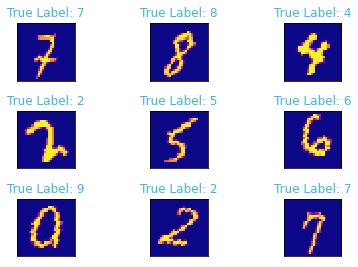

In [40]:
# visulization of the dataset
examples = enumerate(train_data_loader)
batch_idx, (example_data, example_targets) = next(examples)
# the shape to input example_data
print(f'In the {batch_idx}-th batch, the shape of loaded data: {example_data.shape} in format [batch_size, channels, width, height], \n and the targets are in shape {example_targets.shape}')

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='plasma', interpolation='none')
  plt.title("True Label: {}".format(example_targets[i]), color='#3db6e3')
  plt.xticks([])
  plt.yticks([])
#fig.show()

In [41]:
# training params:
epochs = 20
lr = 0.01

In [42]:
# Models
# full-connected neural network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

class FC_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

# for CNN the output size is sepcified as:
# output_size = (input_size - kernel_size + 2 * padding) / stride + 1
class CONV_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                            out_channels=10,
                            kernel_size=3,
                            stride=1,
                            padding=1)
        self.pool = nn.MaxPool2d(2, 2) # size=2, stride=2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(20*7*7, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

        self.droupout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.droupout(x)
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [43]:
epochs = 1
lr = 0.01
log_interval = 100
val_interval = 150

In [44]:
# choose cpu or gpu to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Some tricks when using Tensorboard
1. ``tensorboard --logdir=<log file directory> --host=127.0.0.2`` is useful when localhost is not working.
2. ``tensorboard --inspect --logdir <log file directory>`` is used when checking whether summary_writer finished its job.

In [45]:
# init a SummaryWriter and Visualization
model = model.cpu()
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter("logs/mnist_log")
example_images, exmple_labels = next(iter(train_data_loader)) # initialize the network structure. 
grid = torchvision.utils.make_grid(example_images)
tb.add_image('example_images', grid)
tb.add_graph(model, example_images)

In [46]:
begin_time = time.time()
model = model.cuda()
# training session: 
for epoch in range(epochs):
    model.train()
    for idx, batch in enumerate(train_data_loader):
        data, target = batch 
        data = data.to(device) # which is similar as data = data.cuda()
        target = target.to(device)
        idx_target = target.clone()

        optimizer.zero_grad()
        logit = model(data)
        loss = F.cross_entropy(logit, target)
        loss.backward()
        optimizer.step()
        tb.add_scalar('train_loss', loss.cpu(), epoch * len(train_data_loader.dataset) + idx)

        if idx % log_interval == 0 and idx > 0:
          success_pred = torch.eq(torch.argmax(logit, dim=1).view(-1), idx_target).sum()
          acc = success_pred.cpu()/len(data) # len(data) will return the first dimension of data tesnor
          print('Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch, idx * len(data), len(train_data_loader.dataset),
                    loss, acc))
          
          tb.add_scalar('train_acc', acc, epoch * len(train_data_loader.dataset) + idx)
          tb.add_histogram('conv1.weight', model.conv1.weight, epoch * len(train_data_loader.dataset) + idx)
          tb.add_histogram('conv2.weight', model.conv2.weight, epoch * len(train_data_loader.dataset) + idx)
          tb.add_histogram('fc1.weight', model.fc1.weight, epoch * len(train_data_loader.dataset) + idx)
          tb.add_histogram('fc2.weight', model.fc2.weight, epoch * len(train_data_loader.dataset) + idx)
        
        if idx % val_interval == 0 and idx > 0:
          model.eval()
          val_loss = 0.0
          csuccess_pred = 0
          with torch.no_grad():
            for batch in val_data_loader:
              data, target = batch
              data, target = data.to(device), target.to(device)
              output = model(data) # the model is on cuda.
              val_loss += F.cross_entropy(output, target).cpu().item()
              success_pred += torch.eq(torch.argmax(logit, dim=1).view(-1), idx_target).sum()
          val_loss /= len(val_data_loader.dataset)
          acc = success_pred.cpu() / len(val_data_loader.dataset)
          print('Validation Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(epoch, idx * len(data), 
                      len(val_data_loader.dataset), val_loss, acc))

          tb.add_scalar('val_loss', val_loss, epoch * len(val_data_loader.dataset) + idx)
          tb.add_scalar('val_acc', acc, epoch * len(val_data_loader.dataset) + idx)

print('Train process is finished. Time elpse is {:.4f} s.'.format(time.time()-begin_time))
tb.close()

Train Epoch: 0 [3200/48000] Loss: 1.615074 Acc: 0.4375
Validation Epoch: 0 [4800/12000] Loss: 0.027328 Acc: 0.3762
Train Epoch: 0 [6400/48000] Loss: 0.242764 Acc: 0.8750
Train Epoch: 0 [9600/48000] Loss: 0.185270 Acc: 0.9062
Validation Epoch: 0 [9600/12000] Loss: 0.009380 Acc: 0.9087
Train Epoch: 0 [12800/48000] Loss: 0.120254 Acc: 0.9375
Validation Epoch: 0 [14400/12000] Loss: 0.008894 Acc: 1.0025
Train Epoch: 0 [16000/48000] Loss: 0.164745 Acc: 0.9375
Train Epoch: 0 [19200/48000] Loss: 0.351745 Acc: 0.8750
Validation Epoch: 0 [19200/12000] Loss: 0.007060 Acc: 0.8773
Train Epoch: 0 [22400/48000] Loss: 0.093623 Acc: 0.9375
Validation Epoch: 0 [24000/12000] Loss: 0.006539 Acc: 0.9712
Train Epoch: 0 [25600/48000] Loss: 0.420970 Acc: 0.9062
Train Epoch: 0 [28800/48000] Loss: 0.116511 Acc: 0.9688
Validation Epoch: 0 [28800/12000] Loss: 0.007352 Acc: 0.9713
Train Epoch: 0 [32000/48000] Loss: 0.088041 Acc: 0.9688
Validation Epoch: 0 [33600/12000] Loss: 0.005640 Acc: 0.9713
Train Epoch: 0 [35

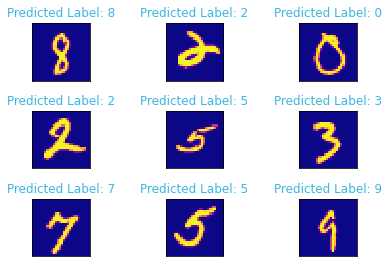

In [47]:
# Give a glance at the training tesults
examples = enumerate(test_data_loader)
_, (example_data, _) = next(examples)
with torch.no_grad():
  pred = model(example_data.cuda()).cpu()
pred = torch.argmax(pred, dim=1)

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='plasma', interpolation='none')
  plt.title("Predicted Label: {}".format(pred[i]), color='#3db6e3')
  plt.xticks([])
  plt.yticks([])

In [48]:
# model test
model.eval()
test_loss = 0
success_pred = 0
with torch.no_grad():
  for data, target in test_data_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    success_pred += torch.eq(torch.argmax(output, dim=1).view(-1), target).sum()
print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
  success_pred, len(test_data_loader.dataset), 100. * success_pred / len(test_data_loader.dataset)))

Test set: Accuracy: 9673/10000 (97%)
